In [1]:
!source activate python3
!pip3 install pymongo
!pip3 install dnspython
!pip3 install pymongo[srv]
!pip3 install xgboost
!source deactivate

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 127.6 MB 21 kB/s s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [8]:
from 01_Data_Creation_for_Tag_Classification import *

SyntaxError: invalid token (<ipython-input-8-e16fd910e055>, line 1)

In [3]:
import nltk
nltk.download(['punkt', 'stopwords'])

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import pickle

In [5]:
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split

import xgboost

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from tensorflow import keras

Using TensorFlow backend.


In [6]:
#feed_hashtag = pd.read_csv(os.getcwd() + '/Datasets/feed_hashtag_long.csv')
#feed_hashtag['createdAt'] = pd.to_datetime(feed_hashtag['createdAt'])
#print(feed_hashtag.shape)
#feed_hashtag.head(1)

In [7]:
feed_hashtag = feed_hashtag[feed_hashtag['isPrimary'] == True]
feed_hashtag = feed_hashtag[~feed_hashtag['text'].isna()]
print("Data Size:", feed_hashtag.shape[0])
print("Unique Content:", feed_hashtag['contentId'].nunique())
print("Unique tags:", feed_hashtag['hashtag'].nunique())

Data Size: 7531
Unique Content: 4487
Unique tags: 12


In [8]:
feed_hashtag['createDate'] = feed_hashtag['createdAt'].dt.date
feed_hashtag.head(1)

,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary,createDate
0,5df454f37e4ea600161b8e2e,5df454297e4ea600161b8e25,2019-12-14 03:20:19.029,5df3940fb2694d0016bdb722,Hi I am Shreshtha. I have been baking for the ...,QUESTION,2019-12-14,12,2019,2019-12,5df3940fb2694d0016bdb722,5df38de0b2694d0016bdb71f,marketingQueries,True,True,2019-12-14


In [9]:
#feed_hashtag.groupby(['createDate']).agg({'contentId':'nunique', 'tagIds':'count'})

In [10]:
feed_hashtag = feed_hashtag.sort_values(['contentId'])

In [11]:
#feed_hashtag.groupby(['contentId'])['hashtag'].count().reset_index().sort_values(['hashtag'], ascending = False).head()

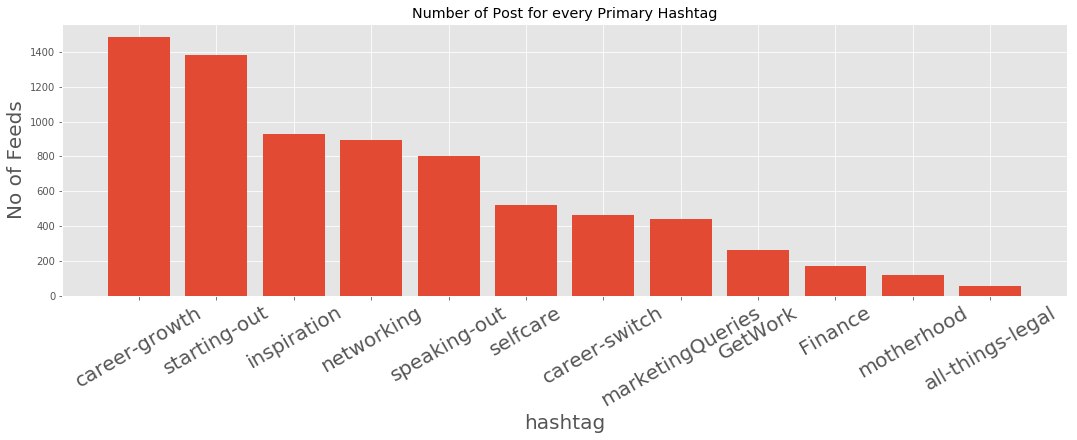

In [12]:
hashtag_class_ct = feed_hashtag.groupby(['hashtag'])['contentId'].agg([('row_count','count'), ('content_count','nunique')]).reset_index()
hashtag_class_ct = hashtag_class_ct.sort_values(['content_count'], ascending=False)
hashtag_class_ct
f, ax = plt.subplots(figsize=(18,5))
plt.bar(hashtag_class_ct['hashtag'], hashtag_class_ct['content_count'])
plt.xlabel('hashtag', fontsize=20)
plt.ylabel('No of Feeds', fontsize=20)
plt.xticks(hashtag_class_ct['hashtag'], fontsize=20, rotation=30)
plt.title('hashtag counts')

plt.title("Number of Post for every Primary Hashtag")
plt.savefig(os.getcwd()+'/Charts/Total_Post_Per_Primary_Hashtag.png')

plt.show()
plt.close()

In [13]:
feed_hashtag_rollup = feed_hashtag.groupby(['contentId', 'authorId_content', 'createdAt', 'text', 'type', 'isActive', 'isPrimary'])['hashtag'].agg([('hashtag_count','count'), ('hashtag_list', ','.join)]).reset_index()
print(feed_hashtag_rollup.shape)
feed_hashtag_rollup.sort_values(['hashtag_count'],ascending=False).head(2)

(4487, 9)


,contentId,authorId_content,createdAt,text,type,isActive,isPrimary,hashtag_count,hashtag_list
1943,5ea903a51081fc002f901eaf,5ea90095cc13d50046a192fe,2020-04-29 04:33:41.016,"Hi, I am teaching spanish language, If anyone ...",POST,True,True,5,"career-growth,career-switch,starting-out,selfc..."
1155,5e883e2239bde20029d8280a,5e7c79d8ad47950024ffd1db,2020-04-04 07:58:26.601,Pinarayi Vijayan (Chief Minister of Kerala) Sa...,POST,True,True,4,"inspiration,networking,selfcare,starting-out"


In [14]:
train_test_cutoff = pd.to_datetime(feed_hashtag['createDate'].max() - timedelta(10))
train_test_cutoff

Timestamp('2020-06-25 00:00:00')

In [15]:
train = feed_hashtag[feed_hashtag['createdAt'] <= train_test_cutoff].copy()
print("train data:", train.shape[0])
test = feed_hashtag[feed_hashtag['createdAt'] > train_test_cutoff].copy()
print("test data:", test.shape[0])

train data: 6533
test data: 998


In [16]:
print("---------------------------------------------------------------------------------------------------")
print("----------------------------------     Data Processing Started     --------------------------------")
print("---------------------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------------------
----------------------------------     Data Processing Started     --------------------------------
---------------------------------------------------------------------------------------------------


# Text Cleansing

In [17]:
def del_stop(sent, stop_word_list):
    return [term for term in sent if term not in stop_word_list]

porter = PorterStemmer()
def stem_tokens(token_list):
    token_stem = [porter.stem(term) for term in token_list]
    return(token_stem)

def get_clean_text(txt):
    feed_token = [word_tokenize(sent.lower()) for sent in txt]
    
    stop_punct = list(punctuation)
    stop_nltk = stopwords.words("english")
    stop_updated = stop_nltk + stop_punct
    
    feed_token_clean = [del_stop(sent, stop_updated) for sent in feed_token]
    feed_token_stemmed = [stem_tokens(tk) for tk in feed_token_clean]
    
    clean_text = [" ".join(sent) for sent in feed_token_clean]
    return(clean_text)

In [18]:
train['text_clean'] = get_clean_text(train.text)
train.head(1)

,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary,createDate,text_clean
0,5df454f37e4ea600161b8e2e,5df454297e4ea600161b8e25,2019-12-14 03:20:19.029,5df3940fb2694d0016bdb722,Hi I am Shreshtha. I have been baking for the ...,QUESTION,2019-12-14,12,2019,2019-12,5df3940fb2694d0016bdb722,5df38de0b2694d0016bdb71f,marketingQueries,True,True,2019-12-14,hi shreshtha baking last 5 years brand associa...


In [19]:
test['text_clean'] = get_clean_text(test.text)
test.head(1)

,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary,createDate,text_clean
18460,5ef3fb8e4446920022aef878,5e94802ee4ffc40045a924dd,2020-06-25 01:19:10.094,5df39410b2694d0016bdb724,Good morning 🌞 We’re all so inundated with sto...,POST,2020-06-25,6,2020,2020-6,5df39410b2694d0016bdb724,5df38de0b2694d0016bdb71f,inspiration,True,True,2020-06-25,good morning 🌞 ’ inundated stories people ’ li...


In [20]:
train_rollup = train.groupby(['contentId', 'authorId_content', 'createdAt', 'text', 'type', 'isActive', 'isPrimary', 'text_clean'])['hashtag'].agg([('hashtag_count','count'), ('hashtag_list', ','.join)]).reset_index()
train_rollup.shape

(3933, 10)

In [21]:
train_df_rollup, validation_rollup = model_selection.train_test_split(train_rollup, test_size=0.20)
print(train_df_rollup.shape, validation_rollup.shape)
train_df = train[train['contentId'].isin(train_df_rollup['contentId'])]
validation = train[train['contentId'].isin(validation_rollup['contentId'])]
print(train_df.shape)
print(validation.shape)

(3146, 10) (787, 10)
(5264, 17)
(1269, 17)


In [22]:
test_rollup = test.groupby(['contentId', 'authorId_content', 'createdAt', 'text', 'type', 'isActive', 'isPrimary', 'text_clean'])['hashtag'].agg([('hashtag_count','count'), ('hashtag_list', ','.join)]).reset_index()
print(test_rollup.shape)
test_rollup.sort_values(['hashtag_count'],ascending=False).head(2)

(554, 10)


,contentId,authorId_content,createdAt,text,type,isActive,isPrimary,text_clean,hashtag_count,hashtag_list
266,5efb7795e46cc7002879418c,5efb7171e46cc7002879413e,2020-06-30 17:34:13.218,"Hey guys, I am a Chef as well as a Baker. ...",POST,True,True,hey guys chef well baker experienced vegan con...,4,"GetWork,career-growth,starting-out,networking"
465,5eff7e7ac5b7700023a25f43,5eff7a0b0bdede002216dcaf,2020-07-03 18:52:42.546,Hey everyone! I am new on this platform and st...,POST,True,True,hey everyone new platform still fluent p learn...,4,"networking,career-growth,starting-out,GetWork"


In [23]:
train_x = train_df['text_clean']
train_y = train_df['hashtag']
valid_x = validation_rollup['text_clean']
valid_y = validation_rollup['hashtag_list']
test_x = test_rollup['text_clean']
test_y = test_rollup['hashtag_list']

In [24]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_enc = encoder.fit_transform(train_y)

In [30]:
mapping = pd.DataFrame({'hashtag':train_y, 'hashtag_encoding':train_y_enc})
mapping = mapping.drop_duplicates()
mapping.sort_values(['hashtag_encoding'])
mapping.to_csv(os.getcwd() + '/Model_Output/encoder_mapping.csv', index=False)

# Feature Creation

In [26]:
text_for_feature = train['text_clean']

In [27]:
def feature_creation_func(feature_type):
    if(feature_type == 'Count Vectorizer'):
        # create a count vectorizer object 
        count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
        count_vect.fit(text_for_feature)
        # transform the training and validation data using count vectorizer object
        xtrain_feature =  count_vect.transform(train_x)
        xvalid_feature =  count_vect.transform(valid_x)
        xtest_feature = count_vect.transform(test_x)
    
    if(feature_type == 'Word TFIDF'):
        # word level tf-idf
        tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
        tfidf_vect.fit(text_for_feature)
        xtrain_feature =  tfidf_vect.transform(train_x)
        xvalid_feature =  tfidf_vect.transform(valid_x)
        xtest_feature = tfidf_vect.transform(test_x)
        pickle.dump(tfidf_vect, open(os.getcwd() + '/Model_Output/tfidf.pkl', "wb"))
        
    if(feature_type == 'N-gram TFIDF'):
        # ngram level tf-idf 
        tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
        tfidf_vect_ngram.fit(text_for_feature)
        xtrain_feature =  tfidf_vect_ngram.transform(train_x)
        xvalid_feature =  tfidf_vect_ngram.transform(valid_x)
        xtest_feature =  tfidf_vect_ngram.transform(test_x)
        
    if(feature_type == 'Character TFIDF'):
        # characters level tf-idf
        tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
        tfidf_vect_ngram_chars.fit(text_for_feature)
        xtrain_feature =  tfidf_vect_ngram_chars.transform(train_x) 
        xvalid_feature =  tfidf_vect_ngram_chars.transform(valid_x) 
        xtest_feature =  tfidf_vect_ngram_chars.transform(test_x)
        
    return(xtrain_feature, xvalid_feature, xtest_feature)

In [28]:
FEATURE_TYPE = 'Word TFIDF'
xtrain_var, xvalid_var, xtest_var = feature_creation_func(FEATURE_TYPE)

# Model Building

### Shallow Neural Networks

In [29]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(1000, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(mapping.shape[0], activation="softmax")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return(classifier)

In [30]:
#train_y_onehot_enc = pd.get_dummies(train_y_enc)
#classifier = create_model_architecture(xtrain_var.shape[1])
#classifier.fit(xtrain_var, train_y_onehot_enc, epochs=5)
#prob_predictions = classifier.predict(xvalid_var)

### All Models

In [31]:
def build_model(model_name):
    #Naive Bayes Model
    if(model_name == 'Naive Bayes'):
        model = naive_bayes.MultinomialNB()
        model.fit(xtrain_var, train_y_enc)
    
    #SVM Model
    if(model_name == 'SVM'):
        model = svm.SVC(probability=True)
        model.fit(xtrain_var, train_y_enc)
    
    #Random Forest Model
    if(model_name == 'Random Forest'):
        model = ensemble.RandomForestClassifier()
        model.fit(xtrain_var, train_y_enc)
    
    #XGBoost Model
    if(model_name == 'XGBoost'):
        model = xgboost.XGBClassifier()
        model.fit(xtrain_var, train_y_enc)
    
    #Shallow Neural Networks Model
    if(model_name == 'Shallow Neural Networks'):
        train_y_onehot_enc = pd.get_dummies(train_y_enc)
        
        model = create_model_architecture(xtrain_var.shape[1])
        model.fit(xtrain_var, train_y_onehot_enc, epochs=5)
    
    return(model)

In [32]:
MODEL_NAME = 'Shallow Neural Networks'
classifier = build_model(MODEL_NAME)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





5158/5158 [==============================] - 11s 2ms/step - loss: 0.2566
Epoch 2/5
5158/5158 [==============================] - 10s 2ms/step - loss: 0.2184
Epoch 3/5
5158/5158 [==============================] - 10s 2ms/step - loss: 0.1927
Epoch 4/5
5158/5158 [==============================] - 10s 2ms/step - loss: 0.1737
Epoch 5/5
5158/5158 [==============================] - 10s 2ms/step - loss: 0.1619


In [33]:
weight = classifier.get_weights()
pklfile= os.getcwd() + '/Model_Output/shallow_neural_network_classifier.pkl'

try:
    fpkl= open(pklfile, 'wb')    #Python 3     
    pickle.dump(classifier, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()
except:
    fpkl= open(pklfile, 'w')    #Python 2      
    pickle.dump(classifier, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()

In [34]:
with open(os.getcwd() + '/Model_Output/shallow_neural_network_classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)

# Prediction for Accuracy

In [35]:
def prediction_accuracy_func(model_name, x_var, measurement_df):
    if(model_name == 'Shallow Neural Networks'):
        prob_predictions = classifier.predict(x_var)
    else:
        prob_predictions = classifier.predict_proba(x_var)
        
    print("Evaluating: ", model_name)
    prob_prediction_df = pd.DataFrame(prob_predictions)
    print("prob_prediction_df", prob_prediction_df.shape)
    prob_prediction_df['contentId'] = list(measurement_df['contentId'])
    
    prob_prediction_df_long = pd.melt(prob_prediction_df, id_vars='contentId', value_vars=range(mapping.shape[0]))
    prob_prediction_df_long.columns = ['contentId', 'hashtag_encoding', 'predicted_prob']
    prob_prediction_df_long['hashtag_rank'] = prob_prediction_df_long.groupby(['contentId'])['predicted_prob'].rank(ascending=False, method = 'first')
    prob_prediction_df_long = prob_prediction_df_long.sort_values(['contentId', 'hashtag_rank'])
    prob_prediction_df_long = pd.merge(prob_prediction_df_long, mapping, how = 'left', on = 'hashtag_encoding')
    prob_prediction_df_long['pred_rank'] = 'pred_rank_' + prob_prediction_df_long['hashtag_rank'].astype(int).map(str)
    prob_prediction_df_long = prob_prediction_df_long.sort_values(['contentId', 'hashtag_rank'])
    print("prob_prediction_df_long", prob_prediction_df_long.shape)
    
    prob_prediction_df_wide = prob_prediction_df_long.pivot_table(index = ['contentId'], columns = 'pred_rank', values = ['hashtag'], aggfunc=lambda x: ''.join(x))
    prob_prediction_df_wide = prob_prediction_df_wide.reset_index()
    prob_prediction_df_wide.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in prob_prediction_df_wide.columns]
    print("prob_prediction_df_wide", prob_prediction_df_wide.shape)
    
    prediction_results = pd.merge(measurement_df[['contentId', 'text', 'hashtag_list', 'hashtag_count']], prob_prediction_df_wide, how = 'right', on='contentId', sort=False, copy=True)
    print("prediction_results", prediction_results.shape)
    
    print("")
    
    print("Exact Match 1st Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_1']))
    print("Exact Match 2nd Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_2']))
    print("Exact Match 3rd Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_3']))
    print("Exact Match 4th Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_4']))
    print("Exact Match 5th Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_5']))
    
    h_list = prediction_results['hashtag_list'].str.split(',')

    top_3_pred = prediction_results[['hashtag_pred_rank_1', 'hashtag_pred_rank_2', 'hashtag_pred_rank_3']].values.tolist()
    
    prediction_results['matching_hashtag_ct'] = [len(set(a) & set(b)) for a,b in zip(h_list, top_3_pred)]
    prediction_results['matching_percent'] = (prediction_results['matching_hashtag_ct']/prediction_results['hashtag_count'])*100
    
    pred_summary = prediction_results.groupby(['matching_percent'])['contentId'].count().reset_index()
    pred_summary['content_proportion'] = (pred_summary['contentId']/sum(pred_summary['contentId']))*100
    pred_summary.sort_values(['matching_percent'], ascending=False)
    
    pred_summary_by_hash_ct = prediction_results.groupby(['matching_percent', 'hashtag_count'])['contentId'].count().reset_index()
    pred_summary_by_hash_ct.sort_values(['hashtag_count', 'matching_percent'], ascending=False)
    
    return(pred_summary, pred_summary_by_hash_ct, prediction_results)


In [36]:
pred_summary_valid, pred_summary_by_hash_ct_valid, prediction_results_valid = prediction_accuracy_func(MODEL_NAME, xvalid_var, validation_rollup)
print("---------------------------------------------------------------------------------------")
print("Validation Data Accuracy")
print(pred_summary_valid)

Evaluating:  Shallow Neural Networks
prob_prediction_df (781, 12)
prob_prediction_df_long (9372, 6)
prob_prediction_df_wide (781, 13)
prediction_results (781, 16)

Exact Match 1st Prediction: 161
Exact Match 2nd Prediction: 83
Exact Match 3rd Prediction: 57
Exact Match 4th Prediction: 56
Exact Match 5th Prediction: 27
---------------------------------------------------------------------------------------
Validation Data Accuracy
   matching_percent  contentId  content_proportion
0          0.000000        162           20.742638
1         25.000000          1            0.128041
2         33.333333         46            5.889885
3         50.000000         66            8.450704
4         66.666667         97           12.419974
5         75.000000          1            0.128041
6        100.000000        408           52.240717


In [37]:
print(pred_summary_by_hash_ct_valid)

    matching_percent  hashtag_count  contentId
0           0.000000              1        144
1           0.000000              2         10
2           0.000000              3          8
3          25.000000              4          1
4          33.333333              3         46
5          50.000000              2         64
6          50.000000              4          2
7          66.666667              3         97
8          75.000000              4          1
9         100.000000              1        301
10        100.000000              2         60
11        100.000000              3         47


In [38]:
prediction_results_valid.head()

,contentId,text,hashtag_list,hashtag_count,hashtag_pred_rank_1,hashtag_pred_rank_10,hashtag_pred_rank_11,hashtag_pred_rank_12,hashtag_pred_rank_2,hashtag_pred_rank_3,hashtag_pred_rank_4,hashtag_pred_rank_5,hashtag_pred_rank_6,hashtag_pred_rank_7,hashtag_pred_rank_8,hashtag_pred_rank_9,matching_hashtag_ct,matching_percent
0,5ef0641d8f7b6900229e3b73,"Hello, I am new to this platform. I recently c...",starting-out,1,starting-out,speaking-out,all-things-legal,motherhood,career-switch,career-growth,networking,GetWork,marketingQueries,inspiration,Finance,selfcare,1,100.000000
1,5e7e04f6c3f6090022544857,Hi all .. i am a freelance architect and inter...,"starting-out,marketingQueries,career-growth",3,career-growth,all-things-legal,motherhood,selfcare,starting-out,networking,GetWork,marketingQueries,career-switch,speaking-out,Finance,inspiration,2,66.666667
2,5e998c2feb763100356efa45,Use these #18daysoflockdown to explore a new i...,selfcare,1,selfcare,Finance,all-things-legal,GetWork,inspiration,speaking-out,starting-out,career-growth,motherhood,career-switch,networking,marketingQueries,1,100.000000
3,5ed06a42bed7c00023730f32,,"inspiration,selfcare",2,speaking-out,Finance,all-things-legal,GetWork,inspiration,starting-out,selfcare,career-growth,networking,marketingQueries,motherhood,career-switch,1,50.000000
4,5ec6e24412997b0024aa69c6,🌸 BELIEVE in YOURSELF 🌸 These three wonderf...,"selfcare,starting-out,speaking-out",3,speaking-out,Finance,all-things-legal,GetWork,starting-out,inspiration,networking,selfcare,career-growth,marketingQueries,career-switch,motherhood,2,66.666667


In [39]:
pred_summary_test, pred_summary_by_hash_ct_test, prediction_results_test = prediction_accuracy_func(MODEL_NAME, xtest_var, test_rollup)
print("---------------------------------------------------------------------------------------")
print("Test Data Accuracy")
print(pred_summary_test)

Evaluating:  Shallow Neural Networks
prob_prediction_df (532, 12)
prob_prediction_df_long (6384, 6)
prob_prediction_df_wide (532, 13)
prediction_results (532, 16)

Exact Match 1st Prediction: 101
Exact Match 2nd Prediction: 53
Exact Match 3rd Prediction: 55
Exact Match 4th Prediction: 29
Exact Match 5th Prediction: 18
---------------------------------------------------------------------------------------
Test Data Accuracy
   matching_percent  contentId  content_proportion
0          0.000000         82           15.413534
1         33.333333         38            7.142857
2         50.000000         31            5.827068
3         66.666667         97           18.233083
4         75.000000          1            0.187970
5        100.000000        283           53.195489


In [40]:
print(pred_summary_by_hash_ct_test)

    matching_percent  hashtag_count  contentId
0           0.000000              1         70
1           0.000000              2          7
2           0.000000              3          5
3          33.333333              3         38
4          50.000000              2         29
5          50.000000              4          2
6          66.666667              3         97
7          75.000000              4          1
8         100.000000              1        209
9         100.000000              2         41
10        100.000000              3         33
